Dataset link shared in Assignment 1

https://drive.google.com/file/d/1PVA5IR4bAn7RulAeuSgxRBNMtmRGXaUm/view

# 1. Extract the text content from the JSON-encoded data set and create a text corpus. You may use any JSON library to extract the text

In [6]:
import json

In [7]:
def json2text(filename):
    file = open(filename)
    paper_content = json.load(file)
    body_text = ""
    abstract = ""
    title = ""
    #get the paper id
    paper_id = paper_content['paper_id']
    #get the title
    if 'title' in paper_content:
        title = paper_content['title']
    #get the abstract
    if 'abstract' in paper_content:
        for abs in paper_content['abstract']:
            abstract = abstract + abs['text']
    #get the paper
    if 'body_text' in paper_content:
        for bt in paper_content['body_text']:
            body_text = body_text + bt['text']
    return (f'{title} {abstract} {body_text}')

In [8]:
import os
import multiprocessing
from concurrent.futures import ProcessPoolExecutor

def process_corpus(function, files):
    cores_num = multiprocessing.cpu_count()

    with ProcessPoolExecutor(max_workers=cores_num) as executor:
        corpus = list(executor.map(function, files))

    return corpus

In [9]:
import os
# Example usage
if __name__ == '__main__':
    # Assuming 'data_folder' contains your JSON files
    data_folder = '/kaggle/input/json-files/pdf_json'

    # Get a list of all JSON files in the directory
    files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.json')]

    # Create the text corpus
    corpus = process_corpus(json2text, files)



# 2. Develop your pre-processing steps (case-folding, removal of numbers, etc.) and order of steps

Pre-processing steps:
1. Text cleaning: case folding, removal of numbers, removal of urls, removal of special characters, removal of white spaces
2. Tokenization
3. Stopword Removal

In [10]:
## Pre-processing steps:
#1 Text cleaning
import re
def text_cleaning(filename):
    #I Case-folding:
    # Python is case-sensitive programming language. So, to avoid any issues and ensure the consistency of processing of text, we convert all text to lowercase.
    filename = filename.lower()

    #II Removal of urls:
    url_pattern = re.compile(r'https?://\S+')#\S+ ensures that the rest of the URL consists of non-whitespace characters, which is typical for URLs.
    filename = url_pattern.sub("", filename)
    # sub():  It allows you to search for a pattern within a string and replace all occurrences of that pattern with another string.

    #III Removal of non-words and non-whitespace characters:
    filename = re.sub(r'[^\w\s]','', filename)
    # This scans the entire DataFrame filename and removes all characters that are not word characters (letters, digits, underscores) or whitespace (spaces, tabs, newlines).
    # [^\w\s]: ^ is negation; \w matches any word characters which includes letters(both uppercase and lowercase), digits, and underscore(_); \s matches any whitespace character (spaces, tabs, newlines).
    # So, [^\w\s] matches characters that are neither word characters nor whitespace.

    #IV Removal of digits:
    filename = re.sub(r'[\d]','', filename)

    return filename

In [11]:
corpus = process_corpus(text_cleaning, corpus)

In [12]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [13]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
#2 Tokenization with removal of stopwords

from nltk.corpus import stopwords

def tokenization(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

In [16]:
tokens = process_corpus(tokenization, corpus)

In [17]:
import itertools

concatenated_tokens = list(itertools.chain(*tokens))

# 3. Find the weighted term frequency for every word in the corpus and order it according to its rank using Zipf’s Law. Find the value of the α using the data obtained from the previous step

In [18]:
from collections import Counter

def weighted_term_frequency(tokens): # these tokens are filtered_tokens, obtained after pre-processing steps.
    term_freq = Counter(tokens)
    total_freq = len(tokens)
    weighted_freq = {word: freq/total_freq for word, freq in term_freq.items()}
    return weighted_freq

'''Zipf’s Law suggests that the frequency of any word is inversely proportional to its rank.'''

def rank_with_freq(weighted_freq): # Weighted Term Frequency
    #sorting with decreasing frequency order
    ranked_terms = sorted(weighted_freq.items(), key = lambda x: x[1], reverse = True)
    return ranked_terms

In [19]:
weighted_freq = weighted_term_frequency(concatenated_tokens)

In [20]:
ranked_freq = rank_with_freq(weighted_freq)

finding the alpha in zipf's law:

$ frequency = \frac{1}{rank^\alpha} $

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_zipfslaw(ranked_terms):
    # Convert ranks and frequencies to logarithmic scale
    ranks = range(1, len(ranked_terms)+1)
    frequencies = [freq for word, freq in ranked_terms]
    log_ranks = np.log(ranks)
    log_frequencies = np.log(frequencies)

    # Perform linear regression on log-log data
    slope, intercept, r_value, p_value, std_error = linregress(log_ranks, log_frequencies)
    # Alpha is the negative slope of the line
    alpha = -slope

    plt.figure(figsize = (10,6))
    plt.loglog(ranks, frequencies, marker = '.', linestyle = 'None', label = 'Data')
    plt.loglog(ranks, np.exp(intercept + slope*log_ranks), 'r', label = f'Fit: alpha = {alpha: .2F}')
    plt.title("Zipf's Law")
    plt.xlabel("log(Rank)")
    plt.ylabel("log(Frequency)")
    plt.legend()
    plt.grid("True")
    plt.show()
    print("Alpha for zipf's law is", alpha)

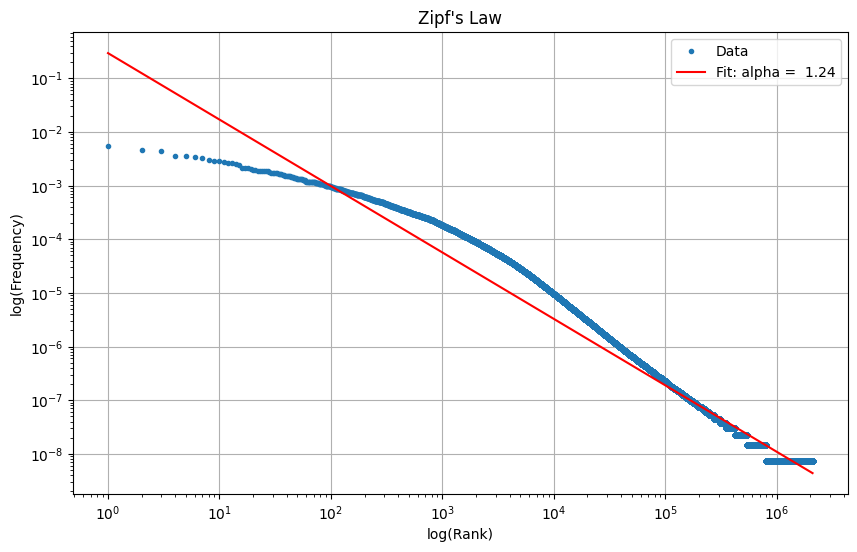

Alpha for zipf's law is 1.2387340410187693


In [32]:
plot_zipfslaw(ranked_freq)

In [23]:
print(type(concatenated_tokens))

<class 'list'>


In [24]:
print(type(concatenated_tokens[1]))

<class 'str'>


# 4. Print the number of tokens and the vocabulary

In [25]:
def tokens_num(tokens):
    num_tokens = len(tokens)
    return num_tokens
def len_vocabulary(tokens):
    vocabulary = set(tokens)
    return len(vocabulary)

In [26]:
print("The total number of tokens are", tokens_num(concatenated_tokens))
print("The total numbers of vocabularies are", len_vocabulary(concatenated_tokens))

The total number of tokens are 133977668
The total numbers of vocabularies are 2089606


# 5. Plot Tokens Vs Vocabulary graph using Heaps’ empirical law. Find Vocabulary count for every 10000 tokens. You may use a log scale for plotting

In [39]:
# Function to calculate vocabulary size every 10,000 tokens
def calculate_vocabulary_size(tokens, step=10000):
    vocab_sizes = []
    seen_tokens = set()
    
    for i in range(step, len(tokens), step):
        seen_tokens.update(tokens[i:i+step])
        vocab_sizes.append(len(seen_tokens))
    
    return vocab_sizes

# Calculate the vocabulary sizes
vocab_sizes = calculate_vocabulary_size(concatenated_tokens)

# Generate the x-axis values representing the number of tokens processed
x_values = np.arange(10000, len(concatenated_tokens) + 1, 10000)



In [40]:
print(len(vocab_sizes))
print(len(x_values))

13397
13397


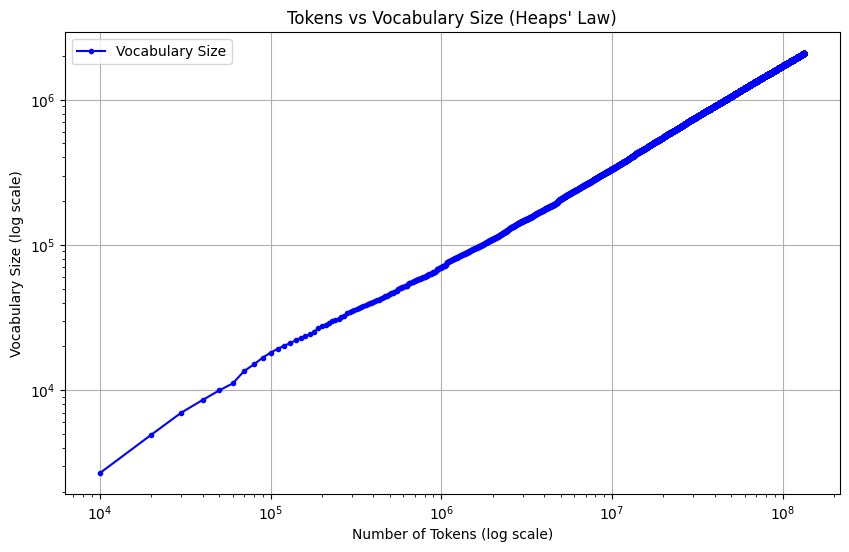

In [42]:
# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(x_values, vocab_sizes, marker='.', color='blue', label='Vocabulary Size')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Tokens (log scale)')
plt.ylabel('Vocabulary Size (log scale)')
plt.title("Tokens vs Vocabulary Size (Heaps' Law)")
plt.legend()
plt.grid(True)
plt.show()